In [3]:
import numpy as np
import cv2
#from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot  as  plt

In [1]:
import torch
from torch import nn
from torchvision import transforms

In [4]:
image = cv2.imread('img/cow_gray.jpg')
image = np.array(image)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
image = cv2.imread('img/fjell.jpg')
image = np.array(image)
fjell_gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [6]:
#def generate_new_im_with_nbh_lin(train_img, nbh_size):
def generate_train_dat(train_img, nbh_size):
    m, n = nbh_size
    
    train_dat = []
    avg = np.mean(train_img)
    train_img = train_img - avg
    for i in range(m, train_img.shape[0]-m):
        for j in range(n, train_img.shape[1]-n):
            neighborhood = train_img[i-m:i,j-n:j+n]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            train_ij = flat_n[:-dlt]

            train_dat.append(train_ij)
    
    train_dat = np.array(train_dat)
    return train_dat

In [6]:
# Plan:

#mer bilder, mixture, skrive sgd, basic om NN, loss i generative, 
# Load more pics, sample random neighboorhood to train model

In [7]:
#ggg= generate_new_im_with_nbh_lin(gray_img, (5,5))
#train_dat1 = generate_train_dat(gray_img, (5,5))
#train_dat2 = generate_train_dat(fjell_gray_img, (5,5))

In [8]:
#train_dat_full = np.concatenate((train_dat1,train_dat2),axis=0)
#train_dat_full = train_dat_full.astype(np.uint8)
#trans = transforms.ToTensor()
#train_dat = trans(train_dat_full)
#train_dat = train_dat[0]

In [9]:
train_dat.shape

NameError: name 'train_dat' is not defined

In [7]:
class MLP(nn.Module):#define neighborhood size
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(44, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 2),#,
        #nn.ReLU()
        #nn.Sigmoid()
        
        )


    def forward(self, x):
        '''Forward pass'''
        out = self.layers(x)
        
        mu = torch.reshape(out[:,0],(out.shape[0],1))
        sig = torch.reshape(torch.exp(out[:,1]),(out.shape[0],1))

        out = torch.cat((mu,sig),dim=1)
        #print(out)
        return out

In [11]:
#train_dat = torch.from_numpy(train_dat)
#train_dat = torch.from_numpy(train_dat_full)

In [8]:
torch.manual_seed(1)
np.random.seed(1)

In [13]:
#train_dat[:,:-1].shape

In [9]:
train_dat1 = generate_train_dat(gray_img, (5,5))
train_dat2 = generate_train_dat(fjell_gray_img, (5,5))
train_dat_full = np.concatenate((train_dat1,train_dat2),axis=0)
train_dat_full = train_dat_full.astype(np.uint8)
trans = transforms.ToTensor()
train_dat = trans(train_dat_full)
train_dat = train_dat[0]
#train_dat = torch.from_numpy(train_dat_full)

In [10]:
train_dat

tensor([[0.1098, 0.1137, 0.1176,  ..., 0.1176, 0.1137, 0.1137],
        [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1137],
        [0.1176, 0.1176, 0.1137,  ..., 0.1137, 0.1137, 0.1176],
        ...,
        [0.9686, 0.9725, 0.9765,  ..., 0.9412, 0.9412, 0.9412],
        [0.9725, 0.9765, 0.9804,  ..., 0.9412, 0.9412, 0.9490],
        [0.9765, 0.9804, 0.9804,  ..., 0.9412, 0.9490, 0.9490]])

In [10]:
train_dat

tensor([[0.1098, 0.1137, 0.1176,  ..., 0.1176, 0.1137, 0.1137],
        [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1137],
        [0.1176, 0.1176, 0.1137,  ..., 0.1137, 0.1137, 0.1176],
        ...,
        [0.9686, 0.9725, 0.9765,  ..., 0.9412, 0.9412, 0.9412],
        [0.9725, 0.9765, 0.9804,  ..., 0.9412, 0.9412, 0.9490],
        [0.9765, 0.9804, 0.9804,  ..., 0.9412, 0.9490, 0.9490]])

In [11]:
train_dat.shape

torch.Size([72200, 45])

In [11]:
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.GaussianNLLLoss(full=False, reduction='mean')
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-4)
trainloader = torch.utils.data.DataLoader(train_dat, batch_size=32, shuffle=True)

In [12]:
trainloader

In [13]:
epochs = 20 #20
loss_vals = []

In [14]:
for e in range(epochs): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
      
      # Get and prepare inputs
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp(inputs)
        mu_s = outputs[:,0]
        sigma_s = outputs[:,1]  #sigma2 
        #sigma_s = torch.exp(outputs[:,1])
        #print(outputs.shape)
      
      # Compute loss
        #loss = loss_function(outputs, targets)
        loss = loss_function(mu_s, targets, sigma_s)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        
        if i % 500 == 0:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            current_loss = 0.0

  # Process is complete.
    loss_vals.append(current_loss)
    print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 0.000
Loss after mini-batch   501: 0.191
Loss after mini-batch  1001: 0.160
Loss after mini-batch  1501: 0.132
Loss after mini-batch  2001: 0.105
Training process has finished.
Starting epoch 2
Loss after mini-batch     1: 0.000
Loss after mini-batch   501: 0.067
Loss after mini-batch  1001: 0.043
Loss after mini-batch  1501: 0.021
Loss after mini-batch  2001: -0.003
Training process has finished.
Starting epoch 3
Loss after mini-batch     1: -0.000
Loss after mini-batch   501: -0.038
Loss after mini-batch  1001: -0.059
Loss after mini-batch  1501: -0.083
Loss after mini-batch  2001: -0.104
Training process has finished.
Starting epoch 4
Loss after mini-batch     1: -0.000
Loss after mini-batch   501: -0.136
Loss after mini-batch  1001: -0.157
Loss after mini-batch  1501: -0.179
Loss after mini-batch  2001: -0.200
Training process has finished.
Starting epoch 5
Loss after mini-batch     1: -0.000
Loss after mini-batch   501: -0.232
Loss aft

In [2]:
print(torch.__version__)

1.8.1


In [17]:
for i, data in enumerate(trainloader, 0):
    inputs, targets = data[:,:-1], data[:,-1]
    inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))
    
    
    print(inputs.dtype)
    print(inputs.shape)
    break

torch.float32
torch.Size([32, 44])


Text(0.5, 1.0, 'loss')

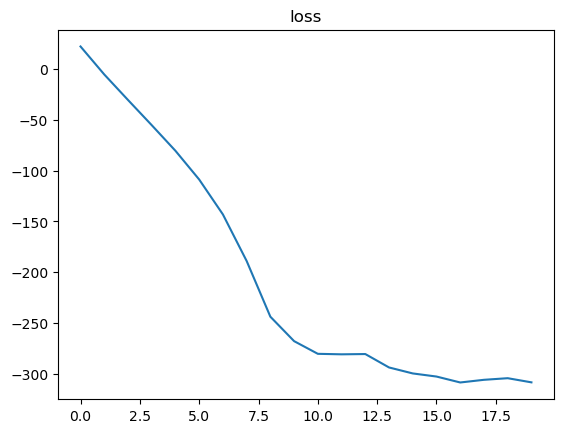

In [15]:
plt.plot(range(len(loss_vals)),loss_vals)
plt.title('loss')

In [16]:
def gen_im(model, im_size, nbh_size):
    m, n = nbh_size
    
    #new_im = np.zeros(im_size)
    #new_im = torch.zeros(im_size)
    #new_im = torch.full(im_size, 100.0)
    #new_im = torch.randint(low=50, high=150, size=im_size,dtype=torch.float)
    
    #new_im = torch.rand(im_size) # prøv med 0.5
    new_im = torch.full(im_size,0.5)
    
    #neighborhood = train_img[i-m:i,j-n:j+n-1]
    #flat_n = neighborhood.flatten()
    
    
    for i in range(m, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i-m:i,j-n:j+n]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]
            #print(nbh_ij.shape)
            output = model(torch.reshape(nbh_ij,(1,44)))
            #print(output)
            sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            
            
            
            new_im[i,j] = sample
    
    return(new_im)

In [17]:
generatted_im = gen_im(mlp, (200,200), (5,5))

In [680]:
#prøv å generere med ku bilde og fjell og et annet bilde, output mu og sigma(sd).
#prøv å starte med ku og generere bilde.
#prøv å trene med imagenet med gpu.
#prøv med mindre naboskap

In [40]:
generatted_im = np.clip(generatted_im, 0, 1)

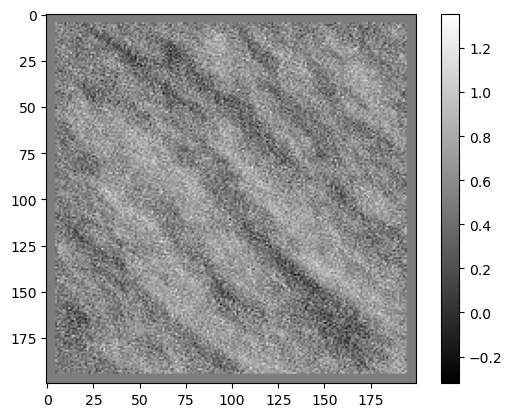

In [18]:
plt.imshow(generatted_im,cmap='gray')
plt.colorbar()

In [661]:
torch.min(generatted_im)

tensor(0.)

In [19]:
trans = transforms.ToTensor()
cow_im = trans(gray_img)
cow_im = cow_im[0]

In [20]:
cow_im.shape

torch.Size([200, 200])

In [21]:
def gen_cow_mu_sigma(model, im_size, nbh_size, cow_im):
    m, n = nbh_size
    
    #new_im = torch.rand(im_size)# prøv med 0.5
    cow_im = cow_im
    
    #cow_mu = torch.zeros(im_size)
    #cow_sigma = torch.zeros(im_size)  #sd
    
    cow_mu = np.zeros(im_size)
    cow_sigma = np.zeros(im_size)  #sd
    #neighborhood = train_img[i-m:i,j-n:j+n-1]
    #flat_n = neighborhood.flatten()
    
    
    for i in range(m, cow_im.shape[0]-m):
        for j in range(n, cow_im.shape[1]-n):
            
            #neighborhood = new_im[i-m:i,j-n:j+n-1]
            neighborhood = cow_im[i-m:i,j-n:j+n] #feil
            flat_n = neighborhood.flatten()
            
            dlt = n #feil
            #print(flat_n.shape)
            nbh_ij = flat_n[:-(dlt+1)]
            #print(nbh_ij.shape)
            output = model(torch.reshape(nbh_ij,(1,44)))
            #print(output)
            cow_mu[i,j] = output.detach().numpy()[0,0]
            cow_sigma[i,j] = np.sqrt(np.abs(output.detach().numpy()[0,1]))
            
            
            #sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            
            
            
            #new_im[i,j] = sample
    
    return cow_mu, cow_sigma

In [22]:
cow_mu, cow_sigma = gen_cow_mu_sigma(mlp, (200,200), (5,5), cow_im)

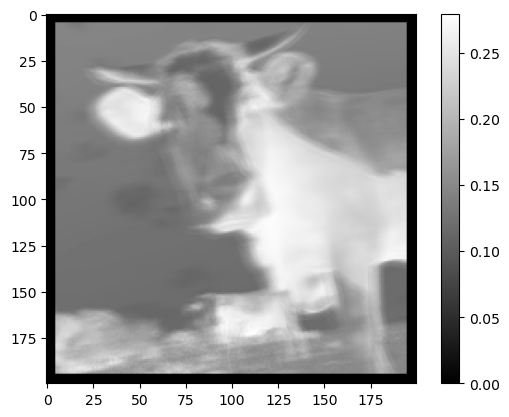

In [23]:
plt.imshow(cow_sigma,cmap='gray')
plt.colorbar()

In [665]:
cow_mu, cow_sigma = gen_cow_mu_sigma(mlp, (200,200), (5,5), cow_im)

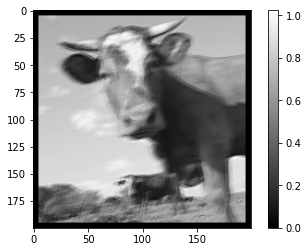

In [666]:
plt.imshow(cow_mu,cmap='gray')
plt.colorbar()

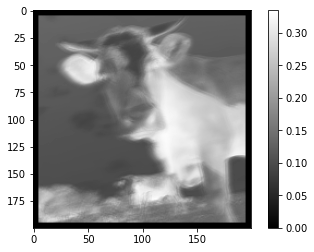

In [667]:
plt.imshow(cow_sigma,cmap='gray')
plt.colorbar()

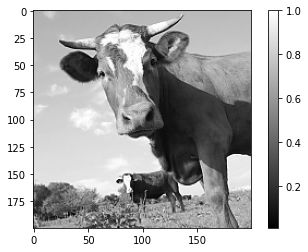

In [668]:
plt.imshow(cow_im,cmap='gray')
plt.colorbar()

In [32]:
koala = cv2.imread('img/KoalaBear.jpg')
koala = np.array(koala)
koala = cv2.cvtColor(koala, cv2.COLOR_BGR2GRAY)

In [33]:
koala_im = trans(koala)
koala_im = koala_im[0]

In [671]:
koala_mu, koala_sigma = gen_cow_mu_sigma(mlp, (200,200), (5,5), koala_im)

In [672]:
#koala_mu[30]

In [673]:
#koala_im[30]

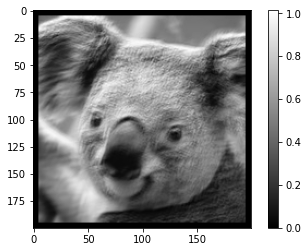

In [674]:
plt.imshow(koala_mu,cmap='gray')
plt.colorbar()

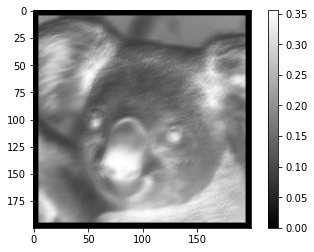

In [675]:
plt.imshow(koala_sigma,cmap='gray')
plt.colorbar()

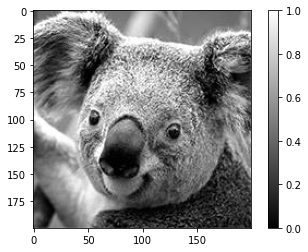

In [676]:
plt.imshow(koala_im,cmap='gray')
plt.colorbar()

In [30]:
def gen_cow(model, im_size, nbh_size, cow_im):
    m, n = nbh_size
    
    #new_im = np.zeros(im_size)
    #new_im = torch.zeros(im_size)
    #new_im = torch.full(im_size, 100.0)
    #new_im = torch.randint(low=50, high=150, size=im_size,dtype=torch.float)
    
    #new_im = torch.rand(im_size) # prøv med 0.5
    new_im = cow_im
    
    #neighborhood = train_img[i-m:i,j-n:j+n-1]
    #flat_n = neighborhood.flatten()
    
    
    for i in range(m, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i-m:i,j-n:j+n]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]
            #print(nbh_ij.shape)
            output = model(torch.reshape(nbh_ij,(1,44)))
            #print(output)
            sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            
            
            
            new_im[i,j] = sample
    
    return(new_im)

In [36]:
new_cow_im = gen_cow(mlp, (200,200), (5,5), koala_im)

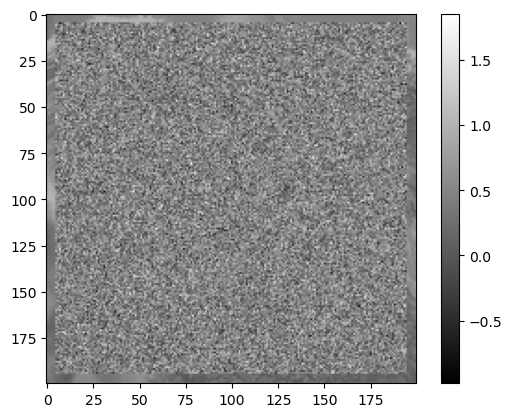

In [37]:
plt.imshow(new_cow_im,cmap='gray')
plt.colorbar()

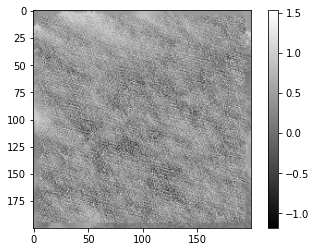

In [679]:
plt.imshow(new_cow_im,cmap='gray')
plt.colorbar()

In [562]:
def nbh_test(im_size, nbh_size):
    new_im = np.zeros(im_size)
    m,n = nbh_size
    for i in range(m, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            neighborhood = new_im[i-m:i,j-n:j+n]
            flat_n = neighborhood.flatten()
            
            dlt = n
            print(flat_n.shape)
            nbh_ij = flat_n[:-(dlt+1)]
            print(nbh_ij.shape)
            

In [563]:
nbh_test((200,200),(5,5))

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,)
(50,)
(44,

In [46]:
mlp(torch.ones((1,42))).detach().numpy()

array([[nan, nan]], dtype=float32)

In [722]:
np.log(0.00001)

-11.512925464970229